In [4]:

import sys
import os

# Standard imports
import copy
import numpy as np
import matplotlib.pyplot as plt
import random

import numpy as np
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from nasbench import api

print("tensorflow version : ", tf.__version__)

# Useful constants
INPUT = 'input'
OUTPUT = 'output'
CONV3X3 = 'conv3x3-bn-relu'
CONV1X1 = 'conv1x1-bn-relu'
MAXPOOL3X3 = 'maxpool3x3'
NUM_VERTICES = 7
MAX_EDGES = 9
EDGE_SPOTS = NUM_VERTICES * (NUM_VERTICES - 1) / 2   # Upper triangular matrix
OP_SPOTS = NUM_VERTICES - 2   # Input/output vertices are fixed
ALLOWED_OPS = [CONV3X3, CONV1X1, MAXPOOL3X3]
ALLOWED_EDGES = [0, 1]   # Binary adjacency matrix

tensorflow version :  2.1.0


In [5]:
# Download NASBench dataset

# !curl -O https://storage.googleapis.com/nasbench/nasbench_only108.tfrecord
# !curl -O https://storage.googleapis.com/nasbench/nasbench_full.tfrecord

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  498M  100  498M    0     0  5028k      0  0:01:41  0:01:41 --:--:-- 6763k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1989M  100 1989M    0     0  5886k      0  0:05:46  0:05:46 --:--:-- 6559k  0:04:39  0:01:02 6328k  0  5926k      0  0:05:43  0:05:15  0:00:28 5066k


In [3]:
# Load dataset
# nasbench = api.NASBench('nasbench_only108.tfrecord')
nasbench = api.NASBench('nasbench_full.tfrecord')

Loading dataset from file... This may take a few minutes...
Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`
Loaded dataset in 182 seconds


In [8]:
def random_spec():
  """Returns a random valid spec."""
  while True:
    matrix = np.random.choice(ALLOWED_EDGES, size=(NUM_VERTICES, NUM_VERTICES))
    matrix = np.triu(matrix, 1)
    ops = np.random.choice(ALLOWED_OPS, size=(NUM_VERTICES)).tolist()
    ops[0] = INPUT
    ops[-1] = OUTPUT
    spec = api.ModelSpec(matrix=matrix, ops=ops)
    if nasbench.is_valid(spec):
      return spec

def run_random_search(max_time_budget=5e6):
  """Run a single roll-out of random search to a fixed time budget."""
  nasbench.reset_budget_counters()
  times, best_valids, best_tests = [0.0], [0.0], [0.0]
  while True:
    spec = random_spec()
    data = nasbench.query(spec)

    # It's important to select models only based on validation accuracy, test
    # accuracy is used only for comparing different search trajectories.
    if data['validation_accuracy'] > best_valids[-1]:
      best_valids.append(data['validation_accuracy'])
      best_tests.append(data['test_accuracy'])
    else:
      best_valids.append(best_valids[-1])
      best_tests.append(best_tests[-1])

    time_spent, _ = nasbench.get_budget_counters()
    times.append(time_spent)
    if time_spent > max_time_budget:
      # Break the first time we exceed the budget.
      break

  return times, best_valids, best_tests

In [14]:
# Run random search 10 times each. This should take a few
# minutes to run. Note that each run would have taken days of compute to
# actually train and evaluate if the dataset were not precomputed.
random_data = []
for repeat in range(50):
  if (repeat + 1) % 10 == 0: print('Running repeat %d' % (repeat + 1))
  times, best_valid, best_test = run_random_search(1e6)
  random_data.append((times, best_valid, best_test))

Running repeat 10
Running repeat 20
Running repeat 30
Running repeat 40
Running repeat 50


Text(0.5, 1.0, 'Random search trajectories (red=validation, blue=test)')

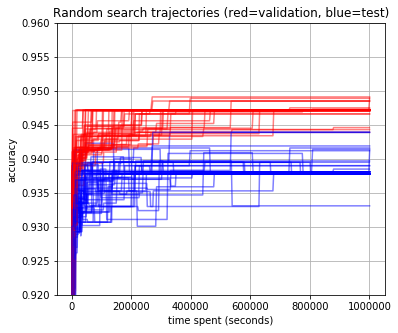

In [15]:
plt.figure(figsize=(20, 5))

plt.subplot(1, 3, 1)
for times, best_valid, best_test in random_data:
  plt.plot(times, best_valid, label='valid', color='red', alpha=0.5)
  plt.plot(times, best_test, label='test', color='blue', alpha=0.5)

plt.ylabel('accuracy')
plt.xlabel('time spent (seconds)')
plt.ylim(0.92, 0.96)
plt.grid()
plt.title('Random search trajectories (red=validation, blue=test)')